In [37]:
import datetime as dt

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx

In [6]:
bikes_df = pd.read_csv('../dataset/processed/processed_dataset.csv')

### Podstawowe parametry danych

In [11]:
# ile wierszy i kolumn
bikes_df.shape

(4643014, 7)

In [12]:
# jakie kolumny
bikes_df.columns

Index(['uid', 'bike_number', 'start_time', 'end_time', 'rental_place',
       'return_place', 'duration'],
      dtype='object')

In [10]:
bikes_df.head(7)

,uid,bike_number,start_time,end_time,rental_place,return_place,duration
0,111139579,651289,2020-12-29 12:46:41,2021-01-05 13:13:00,al. Brücknera / Kwidzyńska,al. Brücknera / Kwidzyńska,10107
1,111184502,651466,2020-12-31 23:39:21,2021-01-01 00:27:47,Zachodnia / Poznańska,Legnicka / Zachodnia,49
2,111184651,650178,2021-01-01 00:10:09,2021-01-01 00:15:27,Traugutta / Kościuszki,Traugutta / Kościuszki,6
3,111184655,651385,2021-01-01 00:10:42,2021-01-01 00:20:17,Pilczycka / Kozanowska,Drzewieckiego / Dedala,10
4,111184679,651165,2021-01-01 00:15:47,2021-01-01 00:41:10,Kozanowska / Pilczycka,Bezpieczna / Obornicka,26
5,111185059,57595,2021-01-01 01:12:57,2021-01-01 01:35:42,Średzka / Dolnobrzeska,Średzka / Dolnobrzeska,23
6,111185061,650971,2021-01-01 01:13:06,2021-01-01 01:35:33,Średzka / Dolnobrzeska,Średzka / Dolnobrzeska,23


In [38]:
# zakres czasu
min_time = bikes_df["start_time"].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).min()
max_time = bikes_df["end_time"].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).max()

print(f"Okres uwzględniony w danych:\n{min_time}  -  {max_time}")

Okres uwzględniony w danych:
2019-03-11 21:29:35  -  2021-12-31 23:58:36


In [39]:
# liczba różnych wartości dla rental_place i return_place
print(f'rental_place: {len(set(bikes_df["rental_place"]))} różnych wartości')
print(f'return_place: {len(set(bikes_df["return_place"]))} różnych wartości')
both = len(
    set.union(
        set(bikes_df["rental_place"]),  set(bikes_df["return_place"])
    )
)
print(f'rental_place i return_place wspólnie: {both} różnych wartości')
rental_not_return = list(
    set(bikes_df["rental_place"]) - set(bikes_df["return_place"])
)
print(f"W rental_place ale nie w return_place: {', '.join(rental_not_return)}")

rental_place: 246 różnych wartości
return_place: 312 różnych wartości
rental_place i return_place wspólnie: 315 różnych wartości
W rental_place ale nie w return_place: # Rowery skradzione Wrocław 2014, #Rowery zapasowe Warszawa, #Magazyn Wrocław 2020/21


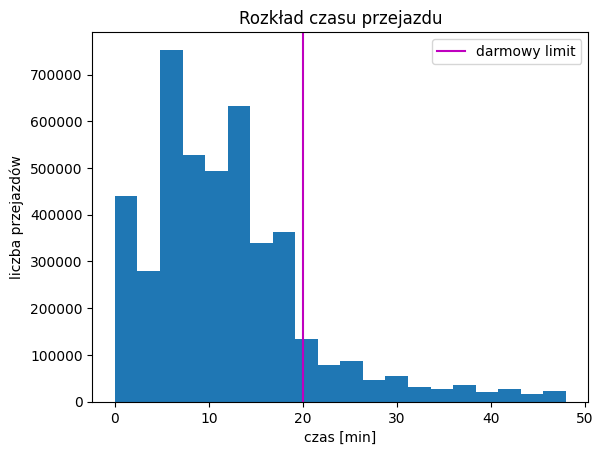

In [31]:
# rozkład czasu przejazdu (bez outlierów)

dur = bikes_df["duration"]
dur_no_outliers = dur[dur < dur.quantile(0.95)]

fig, ax = plt.subplots()
ax.hist(dur_no_outliers, bins=20)
ax.set_title("Rozkład czasu przejazdu")
ax.set_xlabel("czas [min]")
ax.set_ylabel("liczba przejazdów")

# zaznaczamy granicę darmowego przejazdu 20 minut
ax.axvline(ymin=0, ymax=9e5, x=20, c='m', label="darmowy limit")

ax.legend()
plt.show()

### Analizy per rower

In [58]:
bikes_durations_sums = bikes_df.groupby(by='bike_number')['duration'].sum().sort_values()
bikes_durations_means = bikes_df.groupby(by='bike_number')['duration'].mean().sort_values()
bikes_durations_counts = bikes_df.groupby(by='bike_number')['duration'].count().sort_values()

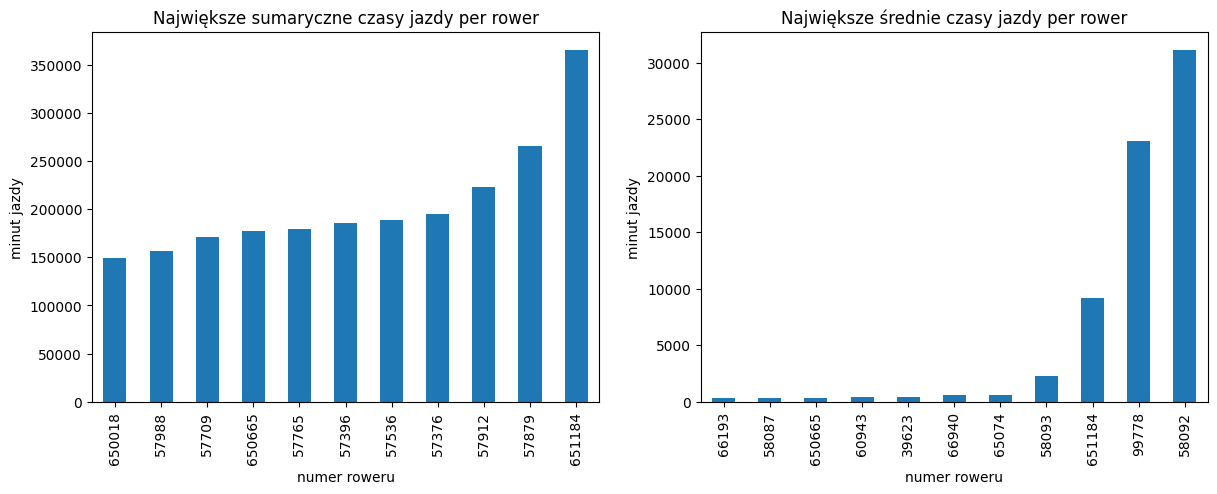

In [57]:
# wykres słupkowy łącznego czasu przejazdu dla 10 z największym czasem
fig, axes = plt.subplots(1, 2, figsize=(6.4*2.25, 4.8))
bikes_durations_sums.iloc[-11:].plot(kind='bar', ax=axes[0])
bikes_durations_means.iloc[-11:].plot(kind='bar', ax=axes[1])
axes[0].set_title('Największe sumaryczne czasy jazdy per rower')
axes[1].set_title('Największe średnie czasy jazdy per rower')
for ax in axes:
    ax.set_xlabel('numer roweru')
    ax.set_ylabel('minut jazdy')
plt.show()

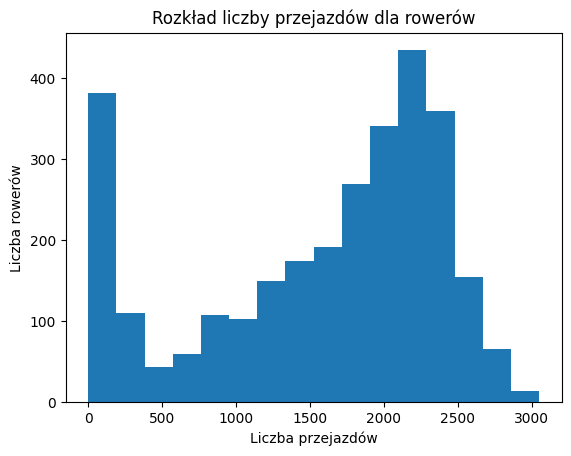

In [64]:
# rozkład liczby przejazdów przez rowery
fig, ax = plt.subplots()
ax.hist(bikes_durations_counts, bins=16)
ax.set_title("Rozkład liczby przejazdów dla rowerów")
ax.set_xlabel("Liczba przejazdów")
ax.set_ylabel("Liczba rowerów")
plt.show()

In [87]:
def get_graph_for_bike(data: pd.DataFrame, bike_number: int) -> nx.Graph:
    """Given data with rides durations, extracts
    rides made with bike with `bike_number` and builds
    graph, where nodes are bike stations
    and edges weights are sums of ride duration
    between given stations
    """
    data_for_bike = data[data["bike_number"] == bike_number]
    edges_series = data_for_bike.drop(columns=['uid']).groupby(['rental_place', 'return_place'])['duration'].sum()
    edges_dict = edges_series.to_dict()
    nodes = list(
        set.union(
            set(data_for_bike["rental_place"]),  set(data_for_bike["return_place"])
        )
    )
    bike_graph = nx.Graph()
    bike_graph.add_nodes_from(nodes)
    for edge, weight in edges_dict.items():
        source, target = edge
        bike_graph.add_edge(source, target, weight=weight)
    return bike_graph

In [138]:
def draw_bike_graph(G: nx.Graph, pos=None, with_labels=True) -> None:
    fig, ax = plt.subplots(figsize=(6.4*2.5, 4.8*1.5))
    nx.draw(graph, with_labels=with_labels, ax=ax, pos=pos)
    plt.show()

Wybrane grafy dla rowerów o dużych średnich czasach przejazdu.

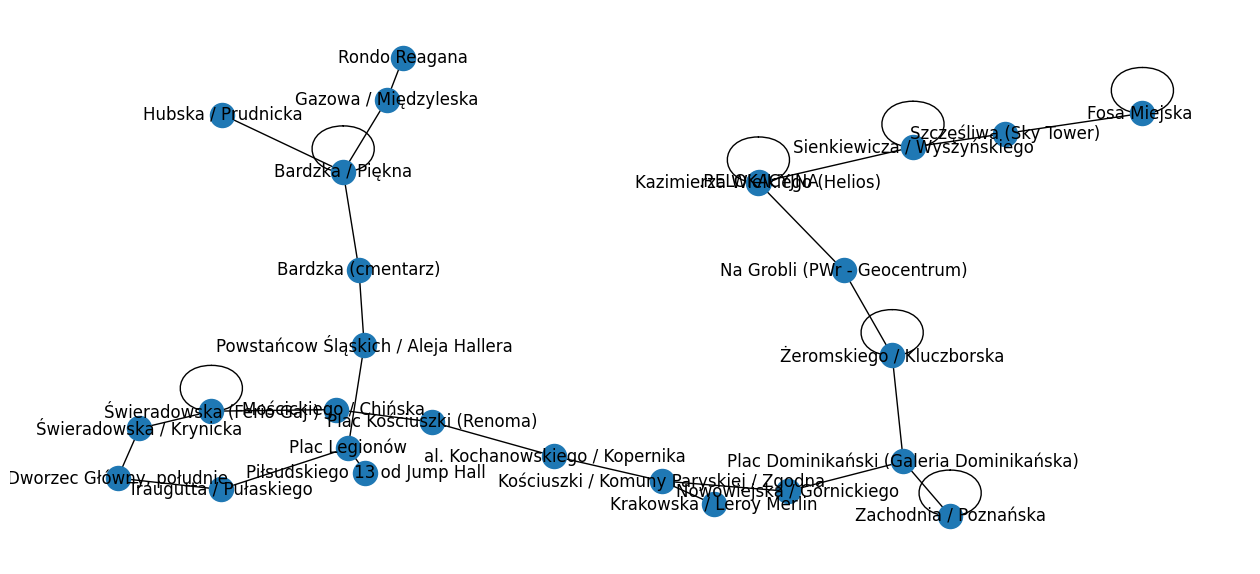

In [105]:
graph = get_graph_for_bike(data=bikes_df, bike_number=651184)
draw_bike_graph(graph)

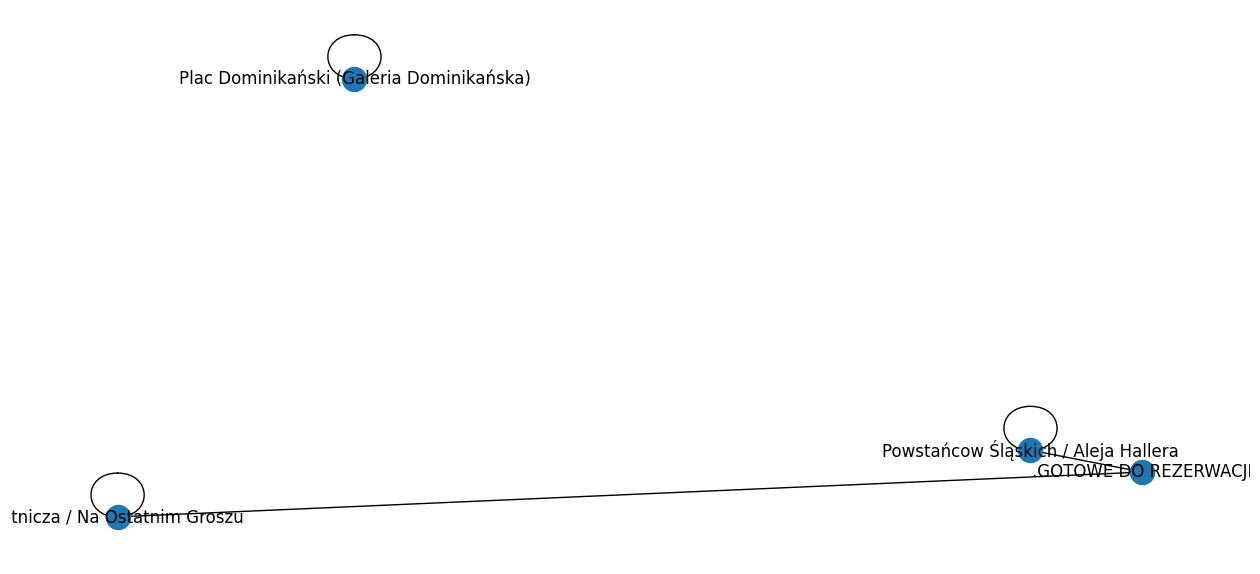

In [119]:
graph = get_graph_for_bike(data=bikes_df, bike_number=58087)
draw_bike_graph(graph)

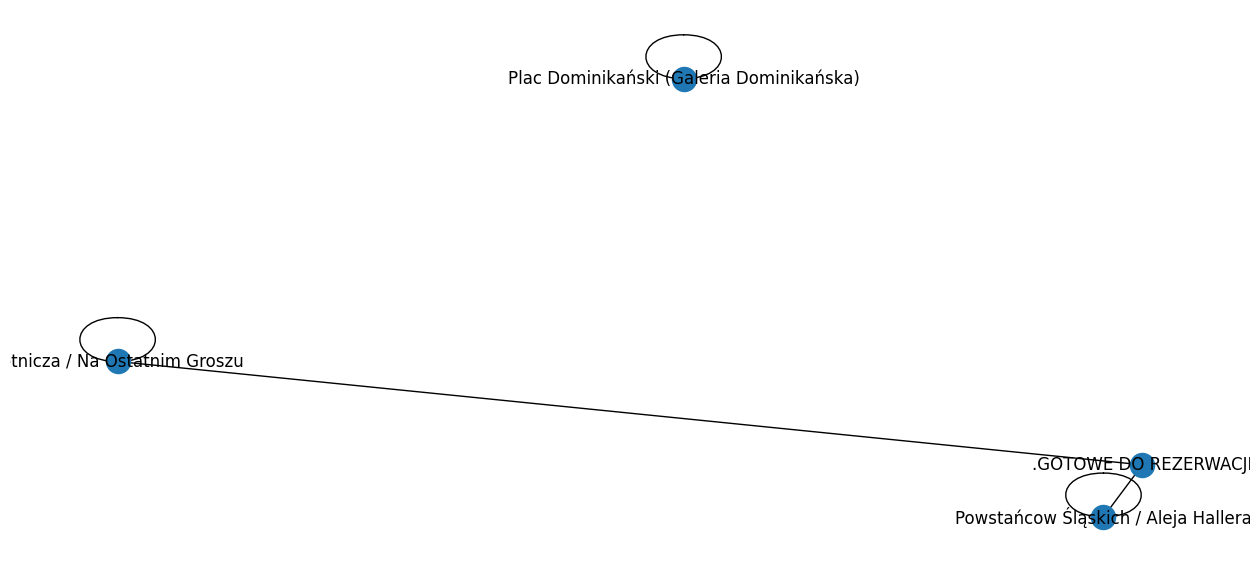

In [123]:
graph = get_graph_for_bike(data=bikes_df, bike_number=bikes_durations_means.index[-10])
draw_bike_graph(graph)

Wybrane grafy dla rowerów o małych średnich czasach przejazdu.

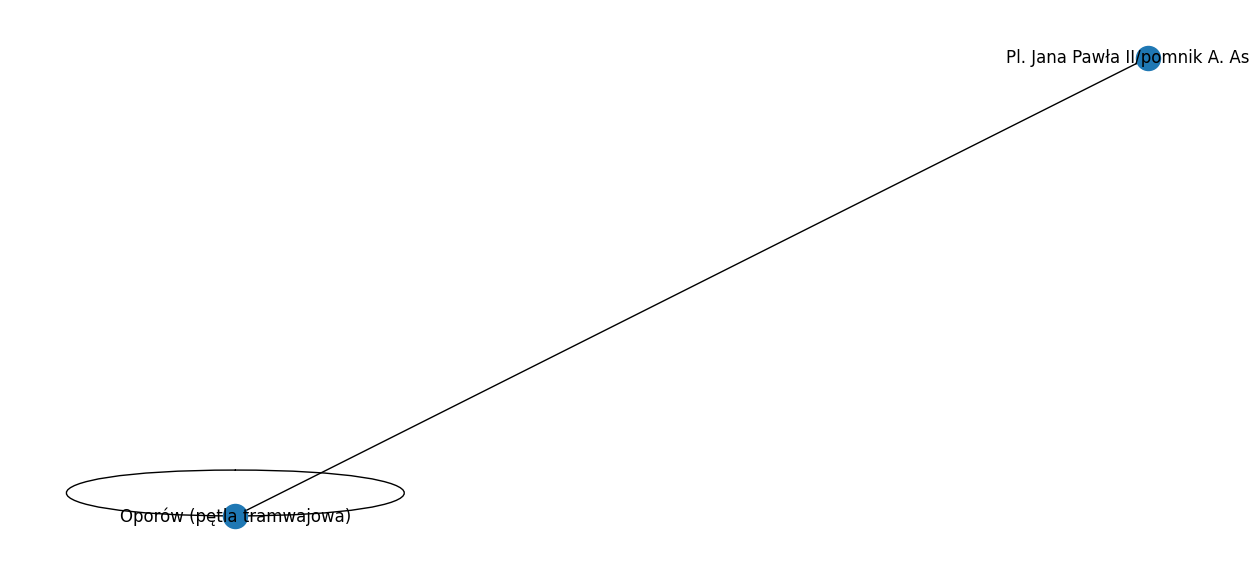

In [130]:
graph = get_graph_for_bike(data=bikes_df, bike_number=bikes_durations_means.index[2])
draw_bike_graph(graph)

Wybrane grafy dla rowerów o dużych sumarycznych czasach przejazdu.

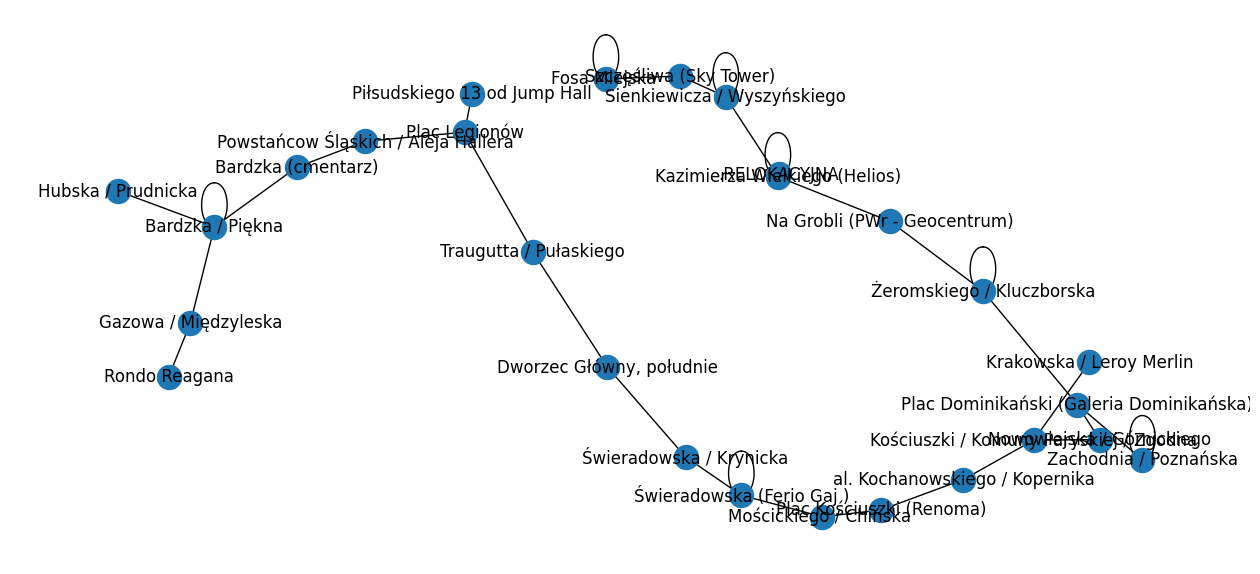

In [131]:
graph = get_graph_for_bike(data=bikes_df, bike_number=651184)
draw_bike_graph(graph)

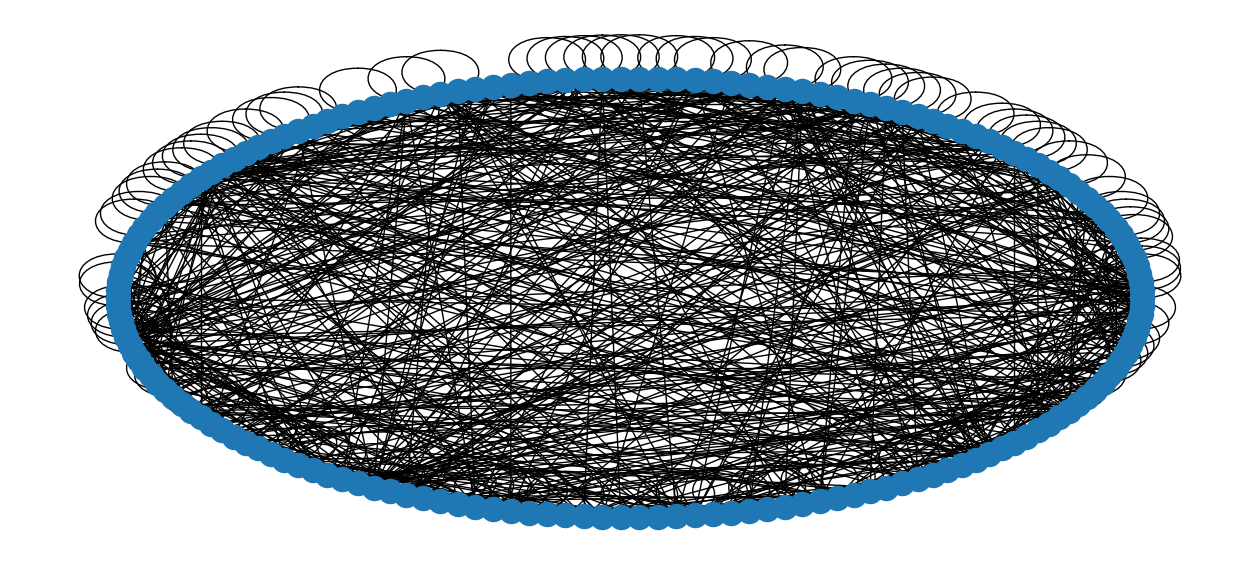

In [139]:
graph = get_graph_for_bike(data=bikes_df, bike_number=57879)
pos = nx.shell_layout(graph)
draw_bike_graph(graph, pos, False)

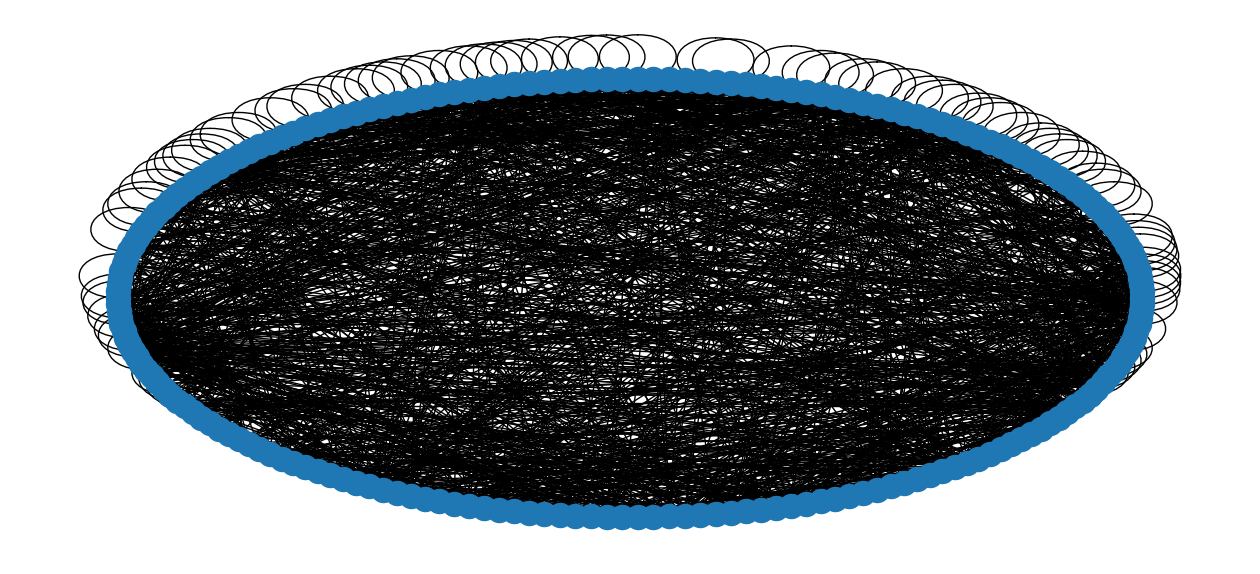

In [140]:
graph = get_graph_for_bike(data=bikes_df, bike_number=57765)
pos = nx.shell_layout(graph)
draw_bike_graph(graph, pos, False)